# Аналитик в Гиперкуб (стажер)
https://yandex.ru/jobs/vacancies/interns/intern_an_hypercube/  

Вам нужно:
+ скачать Access Log серверов NASA за июль 1995 года [отсюда](https://yadi.sk/d/JPx8Chjc6hLHNg);
+ распарсить файл в Pandas DataFrame;
+ посчитать количество обращений к каждому урлу;
+ найти топ-15 самых посещаемых урлов;
+ посчитать число запросов в секунду;
+ нарисовать график числа запросов в секунду;
+ построить гистограмму распределения размеров запросов.  

В качестве ответа приложите файл с кодом или Jupyter Notebook.

+ ## Загрузка Access Log серверов NASA за июль 1995 года [отсюда](https://yadi.sk/d/JPx8Chjc6hLHNg)

In [1]:
YANDI_LINK = 'https://yadi.sk/d/JPx8Chjc6hLHNg'
API_ENDPOINT = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={}'
FILE_EXTENSION = 'log'

### Loading modules

In [2]:
import requests

### Functions

In [3]:
def _get_real_direct_link(sharing_link):
    pk_request = requests.get(API_ENDPOINT.format(sharing_link))
    return pk_request.json().get('href')


def _extract_filename(direct_link):
    for chunk in direct_link.strip().split('&'):
        if chunk.startswith('filename='):
            return chunk.split('=')[1]
    return None


def download_yadisk_link(sharing_link):
    '''Yandex disk link -> name of file(str), file (bytes)'''

    direct_link = _get_real_direct_link(sharing_link)
    if direct_link:
        filename = _extract_filename(direct_link)
        download = requests.get(direct_link)
        file = download.content
        print(f'Download {filename} from {sharing_link}.')
        return filename, file
    else:
        print(f'Failed to download {sharing_link}.')

Загрузка Access Log с Яндекс Диска:

In [4]:
filename, yadisk_file = download_yadisk_link(YANDI_LINK)

Download access_log_Jul95.log.zip from https://yadi.sk/d/JPx8Chjc6hLHNg.


+ ## Распарсить файл в Pandas DataFrame;

### Loading modules

In [5]:
import pandas as pd
import zipfile
import io
import re
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool

### Functions

In [6]:
def zipfile_extract(archive, file_extension, is_file=False):
    '''zip or zip bytes -> string line'''

    if not is_file:
        archive = io.BytesIO(archive)

    with zipfile.ZipFile(archive) as myzip:
        for name in myzip.namelist():
            if name.endswith(file_extension) and not name.startswith('__MACOSX'):  # Hi Mac
                with myzip.open(name) as file:
                    file = io.TextIOWrapper(file, errors='ignore')
                    for line in file:
                        yield line


def count_lines(data, file_extension=None, is_file=False):
    '''zip or text in bytes/file -> count lines'''

    count_lines = 0

    if not is_file:
        data = io.BytesIO(data)

    with zipfile.ZipFile(data) as zip_file:
        for name in zip_file.namelist():
            if name.endswith(file_extension) and not name.startswith('__MACOSX'):
                print(name)
                with zip_file.open(name) as file:
                    count_lines += len(file.readlines())

    return count_lines


def log_parsser(line, regex):

    matches = regex.match(line)
    if matches:
        line_dict = {
            'host': matches.group('host'),
            'identd': matches.group('identd'),
            'userid': matches.group('userid'),
            'time': matches.group('time'),
            'request_method': matches.group('request_method'),
            'request': matches.group('request'),
            'protocol': matches.group('protocol'),
            'status_code': matches.group('status_code'),
            'size_of_object': matches.group('size_of_object')}
    else:
        print(line)
        line_dict = {'host': line}

    return line_dict


def log_parsser_decorator(args):
    return log_parsser(args, regex_comp)


def to_datetime(df, format_date):
    df = pd.to_datetime(df, format=format_date)
    return df


def df_optimizing(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    return df

##  Парсинг Access Log

[About Access Log](http://httpd.apache.org/docs/2.0/logs.html#accesslog)

[Identification Protocol](https://tools.ietf.org/html/rfc1413)  
[HTTP Authentication ](https://tools.ietf.org/html/rfc2617)  
[Hypertext Transfer Protocol](https://tools.ietf.org/html/rfc2616)  
[Method](https://tools.ietf.org/html/rfc2616#section-5.1.1)  
[Hypertext Transfer Protocol Version](https://en.wikipedia.org/wiki/Hypertext_Transfer_Protocol#History)  
[Status Code](https://tools.ietf.org/html/rfc2616#section-6.1.1)  

Количество количество строк в Access Log:

In [7]:
if not filename.endswith(FILE_EXTENSION):
    print(f'Количество строк в Access Log: {count_lines(yadisk_file, FILE_EXTENSION)}')

access_log_Jul95.log
Количество строк в Access Log: 1891715


### Regular expression

[Online regex tester](https://regex101.com/r/lTYzqc/4)

In [8]:
REGEX_PATTERN = r'(?P<host>.*?)\s(?P<identd>[\w,:\s]|-)\s(?P<userid>[\w]+|-)\s\[(?P<time>\d{1,2}\/(\w{3}|\d{2})\/\d{2,4}(:\d{2}){3}\s-?\d{4})\]\s\"(?P<request_method>OPTIONS|GET|HEAD|POST|PUT|DELETE|TRACE|CONNECT)?\s?(?P<request>.*?)\s?(?P<protocol>HTTP\/\d\.\d)?\"\s((?P<status_code>\d{3})|(-))\s((?P<size_of_object>\d+)|(-))'

In [9]:
regex_comp = re.compile(REGEX_PATTERN)

## CPU Info

In [10]:
import subprocess
print((subprocess.check_output('lscpu', shell=True).strip()).decode())

Архитектура:                     x86_64
CPU op-mode(s):                  32-bit, 64-bit
Порядок байт:                    Little Endian
Address sizes:                   39 bits physical, 48 bits virtual
CPU(s):                          12
On-line CPU(s) list:             0-11
Thread(s) per core:              2
Ядер на сокет:                   6
Сокетов:                         1
NUMA node(s):                    1
ID прроизводителя:               GenuineIntel
Семейство ЦПУ:                   6
Модель:                          158
Имя модели:                      Intel(R) Core(TM) i7-8700K CPU @ 3.70GHz
Степпинг:                        10
CPU MHz:                         4490.678
CPU max MHz:                     4700,0000
CPU min MHz:                     800,0000
BogoMIPS:                        7394.00
Виртуализация:                   VT-x
L1d cache:                       192 KiB
L1i cache:                       192 KiB
L2 cache:                        1,5 MiB
L3 cache:                  

## Вариант 1. Парсинг одним процессом одиним потоком

### Распаковка zip-архива

In [11]:
if filename.endswith('zip'):
    log_data = zipfile_extract(yadisk_file, FILE_EXTENSION)

### Парсинг Access Log

In [12]:
%%time

log_list = []

for line in log_data:
    log_list.append(log_parsser(line, regex_comp))

alyssa.p
CPU times: user 8.18 s, sys: 315 ms, total: 8.5 s
Wall time: 8.46 s


## Вариант 2. Парсинг несколькими процессами.

### Распаковка zip-архива

In [13]:
if filename.endswith('zip'):
    log_data = zipfile_extract(yadisk_file, FILE_EXTENSION)

### Парсинг Access Log

In [14]:
%%time

pool_process = Pool()

log_list = pool_process.map(log_parsser_decorator, log_data)

alyssa.p
CPU times: user 2.94 s, sys: 1.06 s, total: 4 s
Wall time: 4.27 s


## Вариант 3. Парсинг одним процессом в несколько потоков (thread).

### Распаковка zip-архива

In [15]:
if filename.endswith('zip'):
    log_data = zipfile_extract(yadisk_file, FILE_EXTENSION)

### Парсинг Access Log

In [16]:
%%time

pool_thread = ThreadPool()

log_list = pool_thread.map(log_parsser_decorator, log_data)

alyssa.p
CPU times: user 14.6 s, sys: 844 ms, total: 15.4 s
Wall time: 15 s


### Удаление скачанного файла

In [17]:
del yadisk_file

## Создание DataFrame

In [18]:
%%time
df = pd.DataFrame(log_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891715 entries, 0 to 1891714
Data columns (total 9 columns):
host              object
identd            object
protocol          object
request           object
request_method    object
size_of_object    object
status_code       object
time              object
userid            object
dtypes: object(9)
memory usage: 129.9+ MB
CPU times: user 2.12 s, sys: 52.1 ms, total: 2.17 s
Wall time: 2.22 s


In [19]:
col_list = [
    'host',
    'identd',
    'userid',
    'time',
    'request_method',
    'request',
    'protocol',
    'status_code',
    'size_of_object'
]

In [20]:
df = df[col_list]
df.head()

,host,identd,userid,time,request_method,request,protocol,status_code,size_of_object
0,199.72.81.55,-,-,01/Jul/1995:00:00:01 -0400,GET,/history/apollo/,HTTP/1.0,200,6245
1,unicomp6.unicomp.net,-,-,01/Jul/1995:00:00:06 -0400,GET,/shuttle/countdown/,HTTP/1.0,200,3985
2,199.120.110.21,-,-,01/Jul/1995:00:00:09 -0400,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085
3,burger.letters.com,-,-,01/Jul/1995:00:00:11 -0400,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0
4,199.120.110.21,-,-,01/Jul/1995:00:00:11 -0400,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179


### Удаление данных log_list

In [21]:
del log_list

### Преобразование типов данных

In [22]:
format_date = '%d/%b/%Y:%H:%M:%S %z'

In [23]:
df['time'] = to_datetime(df['time'], format_date)
df['size_of_object'] = pd.to_numeric(df['size_of_object'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891715 entries, 0 to 1891714
Data columns (total 9 columns):
host              object
identd            object
userid            object
time              datetime64[ns, pytz.FixedOffset(-240)]
request_method    object
request           object
protocol          object
status_code       object
size_of_object    float64
dtypes: datetime64[ns, pytz.FixedOffset(-240)](1), float64(1), object(7)
memory usage: 129.9+ MB


### Оптимизация размера DateFrame

In [24]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891715 entries, 0 to 1891714
Data columns (total 9 columns):
host              object
identd            object
userid            object
time              datetime64[ns, pytz.FixedOffset(-240)]
request_method    object
request           object
protocol          object
status_code       object
size_of_object    float64
dtypes: datetime64[ns, pytz.FixedOffset(-240)](1), float64(1), object(7)
memory usage: 867.1 MB


In [25]:
df = df_optimizing(df)

In [26]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891715 entries, 0 to 1891714
Data columns (total 9 columns):
host              category
identd            category
userid            category
time              datetime64[ns, pytz.FixedOffset(-240)]
request_method    category
request           category
protocol          category
status_code       category
size_of_object    float32
dtypes: category(7), datetime64[ns, pytz.FixedOffset(-240)](1), float32(1)
memory usage: 52.4 MB


## Посчитать количество обращений к каждому урлу

In [27]:
url_count = df.groupby('request') \
              .agg({'request_method': 'count'}) \
              .rename(columns={'request_method': 'count'}) \
              .reset_index()

In [28]:
url_count.head()

,request,count
0,,1
1,,0
2,//www.umcc.umich.edu,1
3,/,32815
4,/,5


## Найти топ-15 самых посещаемых урлов

In [29]:
url_count.nlargest(15, 'count')

,request,count
16164,/images/NASA-logosmall.gif,111329
16150,/images/KSC-logosmall.gif,89637
16155,/images/MOSAIC-logosmall.gif,60466
16178,/images/USA-logosmall.gif,60012
16181,/images/WORLD-logosmall.gif,59487
16284,/images/ksclogo-medium.gif,58800
16303,/images/launch-logo.gif,40871
17758,/shuttle/countdown/,40266
16397,/ksc.html,40200
16291,/images/ksclogosmall.gif,33585


## Посчитать число запросов в секунду

In [30]:
requests_per_second = df.groupby('time') \
                        .agg({'request_method': 'count'}) \
                        .rename(columns={'request_method': 'count'}) \
                        .reset_index()

In [31]:
requests_per_second.head()

,time,count
0,1995-07-01 00:00:01-04:00,1
1,1995-07-01 00:00:06-04:00,1
2,1995-07-01 00:00:09-04:00,1
3,1995-07-01 00:00:11-04:00,2
4,1995-07-01 00:00:12-04:00,3


In [32]:
requests_per_second.nlargest(15, 'count')

,time,count
546758,1995-07-13 13:32:58-04:00,20
534798,1995-07-13 09:42:19-04:00,18
546759,1995-07-13 13:32:59-04:00,18
534799,1995-07-13 09:42:20-04:00,17
444841,1995-07-11 14:47:44-04:00,16
531074,1995-07-13 08:35:02-04:00,16
535117,1995-07-13 09:49:30-04:00,16
208443,1995-07-05 16:29:15-04:00,15
489061,1995-07-12 13:39:35-04:00,15
532233,1995-07-13 08:56:34-04:00,15


## Нарисовать график числа запросов в секунду

### Loading modules

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

sns.set(rc={'figure.figsize': (9, 6)})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

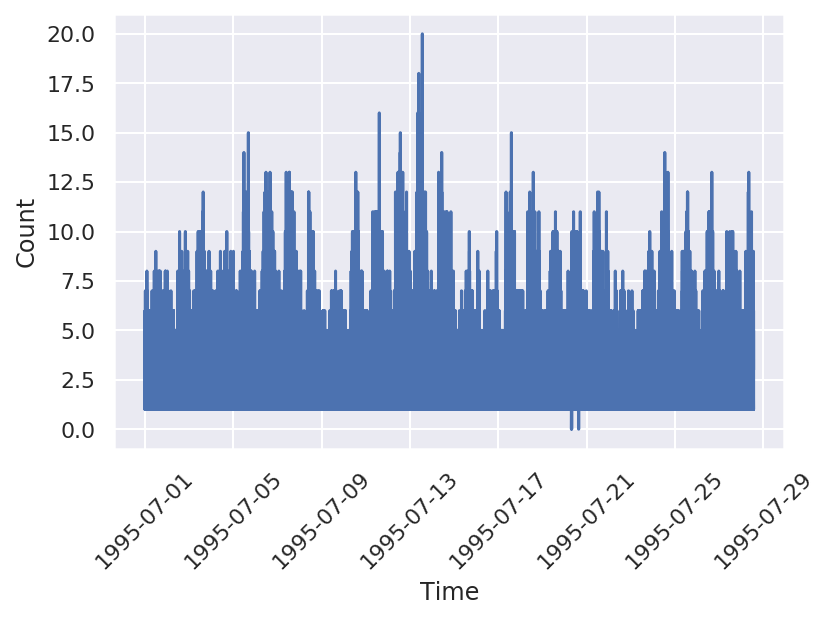

In [34]:
register_matplotlib_converters()
plt.plot(requests_per_second['time'], requests_per_second['count'])
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Построить гистограмму распределения размеров запросов

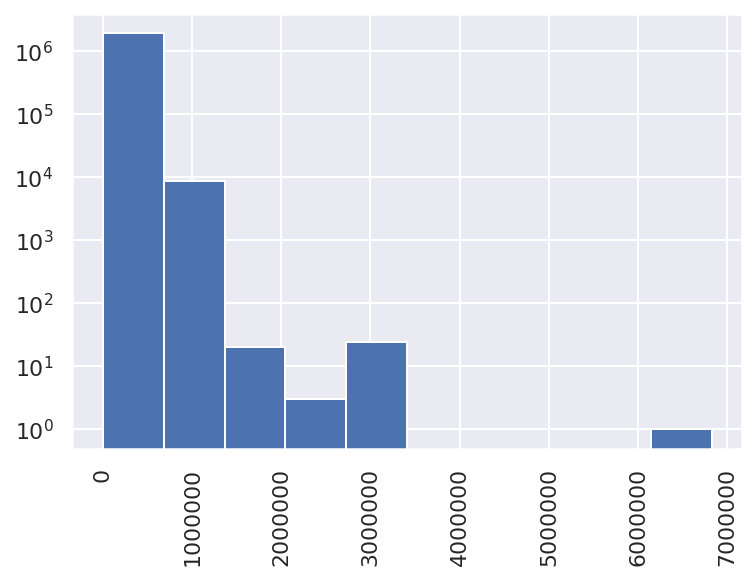

In [35]:
df.size_of_object.hist(log=True)
plt.xticks(rotation='vertical')
plt.show()